<a href="https://colab.research.google.com/github/kangmg/compchem_with_colab/blob/main/ptb_vib_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q condacolab
%pip install -q ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.8 MB/s eta 0:00:00


In [ ]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [ ]:
%%capture
!mamba install xtb -c conda-forge

In [ ]:
!xtb --version

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.7.1 (edcfbbe) compiled by 'conda@afd1a870197c' on 2025-04-11

normal termination of xtb


In [ ]:
#@title viewer UDF
def xyz_viewer(xyzpath:str):
    """view structure from xyz path
    """
    from ase.visualize import view
    from ase.io import read

    display(view(read(xyzpath, format='xyz'), viewer='x3d'))

In [ ]:
#@title xtb wrapper class (deprecated)

import os
import subprocess
import shutil
import json
import ase.io
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt

class xTBWrapper:
    """xTB wrapper class for IR Analysis

    A wrapper for the extended Tight Binding (xTB) program that provides
    structure optimization, vibrational analysis functionality through \
    a simple Python interface.
    """
    def __init__(self, xyzpath:str, job_dir=None):
        """Initialize xTB wrapper

        Parameters:
        -----------
        xyzpath : str
            Path to XYZ structure file
        job_dir : str, optional
            Directory for calculation outputs (defaults to xyz filename without extension)
        """
        assert self._xtb_installed(), 'xtb is not installed'
        self.cwd = os.getcwd()
        self.outfile = dict()
        self.vib_res = dict()

        xyz_name = os.path.splitext(os.path.basename(xyzpath))[0]
        self.job_dir = job_dir if job_dir else xyz_name
        self.xyzpath = os.path.abspath(xyzpath)
        self.atoms = ase.io.read(xyzpath, format='xyz')

    def _excute_ftn_job_dir(self, ftn, **kwargs):
        """Change directory before executing a function

        Creates job directory if it doesn't exist, changes to it,
        executes the function, then returns to original directory.

        Parameters:
        -----------
        ftn : callable
            Function to execute
        **kwargs : dict
            Arguments to pass to function
        """
        os.makedirs(self.job_dir, exist_ok=True)
        try:
            os.chdir(self.job_dir)
            ftn(**kwargs)
        finally:
            os.chdir(self.cwd)

    def _xtb_installed(self):
        """Check if xTB is installed in system path

        Returns:
        --------
        bool
            True if xTB is installed, False otherwise
        """
        try:
            subprocess.run(["xtb", "--version"], check=True)
            return True
        except subprocess.CalledProcessError:
            return False

    def _xtb_optimize(self, xyz_path, solvent=None):
        """Optimize molecular structure in current directory

        Parameters:
        -----------
        xyz_path : str
            Path to XYZ structure file
        solvent : str, optional
            Solvent name for ALPB solvation model

        Raises:
        -------
        RuntimeError
            If xTB execution fails
        AssertionError
            If XYZ file atoms don't match self.atoms
        """
        assert ase.io.read(xyz_path).get_chemical_symbols() == self.atoms.get_chemical_symbols(), 'xyz file is not matching self.atoms'
        cmd_list = ['xtb', xyz_path, '--opt']
        if solvent:
            cmd_list.append(f'--alpb {solvent}')
            phase = f'sol_{solvent}'
        else:
            phase = 'gas'
        cmd_list.extend(['>', f'optimize_{phase}.out'])

        print(' '.join(cmd_list))

        result = subprocess.run(" ".join(cmd_list), shell=True, capture_output=True, text=True)

        if result.returncode != 0:
            print(result.stderr)
            raise RuntimeError('xTB excuation failed !')

        assert os.path.exists('xtbopt.xyz'), 'xtbopt.xyz not found'
        atoms = ase.io.read('xtbopt.xyz', format='xyz')
        self.atoms = atoms

    def xtb_gas_optimize(self):
        """Optimize structure in gas phase using xTB

        Runs geometry optimization in gas and updates self.atoms
        with the optimized structure.
        """
        self._excute_ftn_job_dir(
            ftn=self._xtb_optimize,
            xyz_path=self.xyzpath,
            solvent=None
            )

    def xtb_alpb_optmize(self, solvent='DMF'):
        """Optimize structure with ALPB solvation model

        Performs a two-step optimization: first in gas phase,
        then in specified solvent environment.

        Optimized structure will be stored in self.atoms

        Parameters:
        -----------
        solvent : str, optional
            Solvent name (default: 'DMF')
        """
        if os.path.exists('xtbopt.xyz'):
            os.remove('xtbopt.xyz')

        self._excute_ftn_job_dir(
            ftn=self._xtb_optimize,
            xyz_path=self.xyzpath,
            solvent=None
            )

        self._excute_ftn_job_dir(
            ftn=self._xtb_optimize,
            xyz_path='xtbopt.xyz',
            solvent=solvent
        )

    def ptb_ir_calculation(self, solvent=None):
        """Run PTB method calculation and IR/Raman analysis

        Performs perturbative tight binding calculation with
        vibrational analysis and stores results in self.vib_res.

        Parameters:
        -----------
        solvent : str, optional
            Not implemented for PTB method

        Raises:
        -------
        NotImplementedError
            If solvent is specified (PTB doesn't support solvation)
        RuntimeError
            If xTB execution fails
        """

        cmd_list = ['xtb', 'tmp.xyz', '--ptb', '--hess', '--raman', '--json']
        if solvent:
            raise NotImplementedError('PTB does not yet support solvation methods')
        cmd_list.extend(['>', f'ptb_ir_gas.out'])

        try:
            os.chdir(self.job_dir)
            ase.io.write('tmp.xyz', self.atoms, format='xyz')
            print(' '.join(cmd_list))

            result = subprocess.run(" ".join(cmd_list), shell=True, capture_output=True, text=True)

            if result.returncode != 0:
                print(result.stderr)
                raise RuntimeError('xTB excuation failed !')

            self.vib_res = json.load(open('xtbout.json', 'r'))
        finally:
            os.chdir(self.cwd)


    def gfn_ir_calculation(self, solvent=None):
        """Run GFN-xTB method calculation and IR analysis

        Performs GFN2-xTB calculation with vibrational analysis
        and stores results in self.vib_res.

        Parameters:
        -----------
        solvent : str, optional
            Solvent name for ALPB solvation model

        Raises:
        -------
        RuntimeError
            If xTB execution fails
        """

        cmd_list = ['xtb', 'tmp.xyz', '--hess', '--json']
        if solvent:
            cmd_list.append(f'--alpb {solvent}')
            phase = f'sol_{solvent}'
        else:
            phase = 'gas'
        cmd_list.extend(['>', f'gfn_ir_{phase}.out'])

        try:
            os.chdir(self.job_dir)
            ase.io.write('tmp.xyz', self.atoms, format='xyz')
            print(' '.join(cmd_list))

            result = subprocess.run(" ".join(cmd_list), shell=True, capture_output=True, text=True)

            if result.returncode != 0:
                print(result.stderr)
                raise RuntimeError('xTB excuation failed !')

            self.vib_res = json.load(open('xtbout.json', 'r'))
        finally:
            os.chdir(self.cwd)

    def view(self):
        """View molecular structure using ase.visualize.view x3d viewer

        Displays the current molecular structure in interactive 3D viewer.
        """
        display(view(self.atoms, viewer='x3d'))

    def _excute_xtb(self, cmd_list:list):
        """Execute xTB command and print stderr

        Parameters:
        -----------
        cmd_list : list
            Command to execute as list of strings
        """
        res = subprocess.run(
            cmd_list,
            shell=True,
            capture_output=True,
            text=True
            )
        print(res.stderr)

    def _plot_ir_spectrum(self, freq, intensity, **kwargs):
        """Plot IR spectrum with Lorentzian broadening

        Parameters:
        -----------
        freq : array-like
            Peak frequencies in cm⁻¹
        intensity : array-like
            Peak intensities
        **kwargs : dict, optional
            num_points : int
                Number of points for spectrum plot (default: 1000)
            bar_width : float
                Width of bars for peak visualization (default: 5)
            intensity_scale : float
                Scaling factor for peak heights (default: 0.9)
            gamma_or_sigma : float
                Half-width for Lorentzian broadening (default: 20 cm⁻¹)
            freq_padding : float
                Padding for frequency range (default: 30 cm⁻¹)
            xrng : tuple
                X-axis range as (min, max)
            annotate : bool
                Whether to annotate peaks with frequency values (default: False)
        """
        num_points = kwargs.get('num_points', 1000)
        bar_width = kwargs.get('bar_width',5)
        intensity_scale = kwargs.get('intensity_scale', 0.9)
        gamma_or_sigma = kwargs.get('gamma_or_sigma', 20)
        freq_padding = kwargs.get('freq_padding', 30)
        xrng = kwargs.get('xrng', None)
        annotate = kwargs.get('annotate', False)


        freq = np.array(freq)
        intensity = np.array(intensity)

        # set x range
        x = np.linspace((freq[0]-freq_padding), (freq[-1]+freq_padding), num_points)

        def _lorentzian(x, x0, gamma, A):
            return A * (gamma / ((x - x0)**2 + gamma**2))

        # initialize spectrum
        spectrum = np.zeros_like(x)

        for f, i in zip(freq, intensity):
            spectrum += _lorentzian(x, f, gamma_or_sigma, i)

        # normalization
        spectrum /= np.max(spectrum)
        intensity /= np.max(intensity)
        intensity *= intensity_scale

        # plot
        plt.figure(figsize=(6, 3))
        plt.plot(x, spectrum, color='tab:cyan', ls='-')
        plt.bar(freq, intensity, width=bar_width, color='violet', label='Original Peaks')
        if annotate:
            for x_pos, y_pos in zip(freq, intensity):
                plt.annotate(
                    f"{x_pos:.2f}", (x_pos, y_pos), textcoords="offset points", xytext=(0, 10),
                    ha="center", color="lightcoral", fontsize=7, rotation=45,
                    )
        plt.xlabel('Frequency (cm⁻¹)')
        plt.ylabel('Norm. Intensity')
        if xrng:
            plt.xlim(xrng)
        plt.ylim(0, 1.1)
        plt.gca().invert_xaxis()
        plt.show()

    def ir_spectrum(self, **kwargs):
        """Plot IR spectrum from calculation results

        Generates a plot of the IR spectrum using frequencies and
        intensities from self.vib_res. All plotting parameters
        are passed to _plot_ir_spectrum.

        Parameters:
        -----------
        **kwargs : dict
            Parameters passed to _plot_ir_spectrum
        """
        plot_data = (self.vib_res['vibrational frequencies / rcm'], self.vib_res['IR intensities / km/mol'])
        self._plot_ir_spectrum(*plot_data, **kwargs)

In [ ]:
#@title bpy.xyz
%%writefile bpy.xyz
28

Mn   -0.06239800  -1.89712300   0.13739800
N    -1.37026900  -0.33613700  -0.05779200
N     1.37347500  -0.43284000   0.19801200
C    -2.60597400  -0.32341800  -0.49901200
C    -0.74384300   0.86685800   0.40293500
C     0.74999200   0.81758900   0.53035800
C     2.67261300  -0.50909800   0.02197400
O    -2.22675000  -4.23515200   0.37037700
O     0.23502800  -2.21482100  -3.02334300
O     1.79269100  -4.42668900   0.72819300
C    -1.47749100  -3.39612200   0.28134600
C     0.12946000  -2.10278100  -1.90600400
C     1.15728900  -3.51825200   0.51749000
C    -3.43311200   0.90644500  -0.33957700
H    -3.07127557  -1.14037591  -1.00986836
C    -1.46747300   2.00624500   0.53385500
C     1.50636300   1.91382000   0.78874000
C     3.52263000   0.68765600   0.27539600
H     3.18809528  -1.38397358  -0.31532518
C    -2.91189000   2.03258500   0.19399600
C     2.98882700   1.85670500   0.67777600
H    -3.47413090   2.93216906   0.33375898
H     3.62009928   2.70132874   0.85945167
H    -4.46449700   0.86297300  -0.65854000
H    -1.01186500   2.93426900   0.83524200
H     1.04815600   2.86094200   1.00878900
H     4.59327000   0.60194800   0.13625300
H    -0.21613400  -1.72860100   1.85089700

Writing bpy.xyz


In [ ]:
#@title OMe.xyz
%%writefile OMe.xyz
32

Mn   -0.06239800  -1.89712300   0.13739800
N    -1.37026900  -0.33613700  -0.05779200
N     1.37347500  -0.43284000   0.19801200
C    -2.60597400  -0.32341800  -0.49901200
C    -0.74384300   0.86685800   0.40293500
C     0.74999200   0.81758900   0.53035800
C     2.67261300  -0.50909800   0.02197400
O    -2.22675000  -4.23515200   0.37037700
O     0.23502800  -2.21482100  -3.02334300
O     1.79269100  -4.42668900   0.72819300
C    -1.47749100  -3.39612200   0.28134600
C     0.12946000  -2.10278100  -1.90600400
C     1.15728900  -3.51825200   0.51749000
C    -3.43311200   0.90644500  -0.33957700
H    -3.07127557  -1.14037591  -1.00986836
C    -1.46747300   2.00624500   0.53385500
C     1.50636300   1.91382000   0.78874000
C     3.52263000   0.68765600   0.27539600
O     3.35671098  -1.67014784  -0.42565669
C    -2.91189000   2.03258500   0.19399600
C     2.98882700   1.85670500   0.67777600
H    -3.47413090   2.93216906   0.33375898
H     3.62009928   2.70132874   0.85945167
H    -4.46449700   0.86297300  -0.65854000
H    -1.01186500   2.93426900   0.83524200
H     1.04815600   2.86094200   1.00878900
H     4.59327000   0.60194800   0.13625300
H    -0.21613400  -1.72860100   1.85089700
C     4.43009421  -1.55063221  -1.34759185
H     5.34898553  -1.43383399  -0.81196426
H     4.27034523  -0.69670161  -1.97223798
H     4.47976984  -2.43130422  -1.95327259

Writing OMe.xyz


In [ ]:
#@title MeOMe.xyz
%%writefile MeOMe.xyz
35

Mn   -0.06239800  -1.89712300   0.13739800
N    -1.37026900  -0.33613700  -0.05779200
N     1.37347500  -0.43284000   0.19801200
C    -2.60597400  -0.32341800  -0.49901200
C    -0.74384300   0.86685800   0.40293500
C     0.74999200   0.81758900   0.53035800
C     2.67261300  -0.50909800   0.02197400
O    -2.22675000  -4.23515200   0.37037700
O     0.23502800  -2.21482100  -3.02334300
O     1.79269100  -4.42668900   0.72819300
C    -1.47749100  -3.39612200   0.28134600
C     0.12946000  -2.10278100  -1.90600400
C     1.15728900  -3.51825200   0.51749000
C    -3.43311200   0.90644500  -0.33957700
H    -3.07127557  -1.14037591  -1.00986836
C    -1.46747300   2.00624500   0.53385500
C     1.50636300   1.91382000   0.78874000
C     3.52263000   0.68765600   0.27539600
C     3.35671098  -1.67014784  -0.42565669
C    -2.91189000   2.03258500   0.19399600
C     2.98882700   1.85670500   0.67777600
H    -3.47413090   2.93216906   0.33375898
H     3.62009928   2.70132874   0.85945167
H    -4.46449700   0.86297300  -0.65854000
H    -1.01186500   2.93426900   0.83524200
H     1.04815600   2.86094200   1.00878900
H     4.59327000   0.60194800   0.13625300
H    -0.21613400  -1.72860100   1.85089700
O     4.43009421  -1.55063221  -1.34759185
H     2.62505632  -2.30241304  -0.88372019
H     3.74964928  -2.15210484   0.44509984
C     5.26880051  -2.66619064  -1.60931911
H     4.68100497  -3.47049814  -1.99981345
H     5.74140044  -2.97789995  -0.70136173
H     6.01597789  -2.39076928  -2.32400019


Writing MeOMe.xyz


In [ ]:
#@title EtOMe.xyz
%%writefile EtOMe.xyz
38

Mn    0.29601130  -1.92674958  -2.04588122
N    -0.78088811  -0.33084825  -2.73775519
N     1.28453204  -0.52403933  -0.92126541
C    -1.51685603  -0.21674611  -3.81809570
C    -0.65512668   0.75983689  -1.81771940
C     0.47605181   0.66006909  -0.83757213
C     2.43974901  -0.59314544  -0.30057039
O    -1.37283635  -4.22704120  -3.50488238
O     2.42010778  -1.68827412  -4.41464071
O     1.66729311  -4.55615687  -0.86482169
C    -0.79284083  -3.40006850  -3.00188313
C     1.66890925  -1.77283197  -3.57756560
C     1.19875026  -3.61271733  -1.26951747
C    -2.38575590   0.98151689  -3.99506628
H    -1.51807035  -0.92178339  -4.62296896
C    -1.41593180   1.87208282  -1.96959998
C     0.83472807   1.67882354  -0.01655357
C     2.86768157   0.52360715   0.58752258
C     3.35671098  -1.67014784  -0.42565669
C    -2.38053593   1.98575954  -3.09172068
C     2.09747747   1.61355423   0.76733323
H    -2.99528371   2.85732667  -3.17748731
H     2.42306720   2.40061391   1.41496615
H    -3.02415751   1.01483448  -4.86610907
H    -1.30940983   2.72352069  -1.31894805
H     0.25225887   2.58102288   0.03015060
H     3.81827279   0.44310985   1.10023415
H    -0.84913475  -2.05982611  -0.75784225
H     3.63466304  -2.02624313  -1.39562514
C     2.75214507  -2.84979665   0.31820400
H     4.25918952  -1.36565038   0.06190232
H     3.28194061  -3.00266154   1.23518220
H     2.82597739  -3.72896400  -0.28719963
O     1.38627478  -2.58222539   0.59963604
C     0.83254639  -2.95807421   1.85204274
H     1.23834676  -2.33624465   2.62246734
H    -0.23053748  -2.84046243   1.82170877
H     1.07258344  -3.98072746   2.05566629


Writing EtOMe.xyz


In [ ]:
#@title PrOMe.xyz
%%writefile PrOMe.xyz
41

Mn    2.32977523  -0.77366734   3.23842177
N     1.54614134  -0.95194634   5.11976106
N     1.89223658  -2.77169901   3.07730258
C     1.68843155  -0.17553671   6.16797157
C     0.72239123  -2.12224908   5.18061437
C     0.91963244  -3.11764910   4.07586020
C     2.32894796  -3.67106115   2.22583614
O     2.76543646   2.39094935   3.26030572
O     5.28592161  -1.38914941   4.26898391
O     3.30967430  -0.24427112   0.24699476
C     2.60856618   1.27358564   3.27360824
C     4.24094698  -1.17108997   3.90481072
C     2.96238774  -0.45584307   1.29961939
C     0.83685360  -0.39781403   7.37111228
H     2.41282724   0.60841423   6.24261607
C    -0.04373142  -2.36157618   6.27366597
C     0.34531282  -4.34676917   4.07710896
C     1.73160086  -5.03566462   2.22347433
C     3.37341677  -3.45140960   1.28922624
C    -0.03594040  -1.42723364   7.42669750
C     0.75177439  -5.37570964   3.08245066
H    -0.67081564  -1.61544194   8.26718015
H     0.33373806  -6.36036886   3.05812243
H     0.93699608   0.29674096   8.19266391
H    -0.63737631  -3.25551326   6.36368577
H    -0.36105857  -4.62494663   4.83807681
H     2.09662926  -5.76011156   1.50590374
H     0.73029920  -0.44277302   2.67247247
H     4.29895332  -3.02159888   1.61101008
C     2.50286141  -2.59080318   0.40899742
H     3.60766154  -4.40271560   0.85905617
H     2.43765727  -3.09339216  -0.53336809
H     3.15297661  -1.74580102   0.31832464
C     1.08650710  -2.31658785   0.76870896
H     0.65442103  -3.27086665   0.98677687
O     0.85156879  -1.43147823   1.85396698
H     0.64173844  -1.91818096  -0.11918337
C    -0.46256621  -0.96085945   2.11467209
H    -0.57321562   0.02645091   1.71733725
H    -0.63133473  -0.94116212   3.17109492
H    -1.17337881  -1.61324623   1.65203083


Writing PrOMe.xyz


In [ ]:
#@title DiMeOMe.xyz
%%writefile DiMeOMe.xyz
42

Mn   -0.06239800  -1.89712300   0.13739800
N    -1.37026900  -0.33613700  -0.05779200
N     1.37347500  -0.43284000   0.19801200
C    -2.60597400  -0.32341800  -0.49901200
C    -0.74384300   0.86685800   0.40293500
C     0.74999200   0.81758900   0.53035800
C     2.67261300  -0.50909800   0.02197400
O    -2.22675000  -4.23515200   0.37037700
O     0.23502800  -2.21482100  -3.02334300
O     1.79269100  -4.42668900   0.72819300
C    -1.47749100  -3.39612200   0.28134600
C     0.12946000  -2.10278100  -1.90600400
C     1.15728900  -3.51825200   0.51749000
C    -3.43311200   0.90644500  -0.33957700
C    -3.26696315  -1.48395634  -1.22471449
C    -1.46747300   2.00624500   0.53385500
C     1.50636300   1.91382000   0.78874000
C     3.52263000   0.68765600   0.27539600
C     3.35671098  -1.67014784  -0.42565669
C    -2.91189000   2.03258500   0.19399600
C     2.98882700   1.85670500   0.67777600
H    -3.47413090   2.93216906   0.33375898
H     3.62009928   2.70132874   0.85945167
H    -4.46449700   0.86297300  -0.65854000
H    -1.01186500   2.93426900   0.83524200
H     1.04815600   2.86094200   1.00878900
H     4.59327000   0.60194800   0.13625300
H    -0.21613400  -1.72860100   1.85089700
O     4.43009421  -1.55063221  -1.34759185
H     2.62505632  -2.30241304  -0.88372019
H     3.74964928  -2.15210484   0.44509984
C     5.26880051  -2.66619064  -1.60931911
H     4.68100497  -3.47049814  -1.99981345
H     5.74140044  -2.97789995  -0.70136173
H     6.01597789  -2.39076928  -2.32400019
O    -4.06546829  -0.98456308  -2.28744489
H    -2.51368060  -2.13338462  -1.61931341
H    -3.88385830  -2.02778901  -0.54018078
C    -5.22637841  -1.69258111  -2.69658809
H    -5.90720598  -1.76666678  -1.87446575
H    -4.94986983  -2.67425005  -3.02026864
H    -5.69683129  -1.17033331  -3.50332926


Writing DiMeOMe.xyz


In [ ]:
xyz_viewer('bpy.xyz')
xyz_viewer('OMe.xyz')
xyz_viewer('MeOMe.xyz')
xyz_viewer('EtOMe.xyz')
xyz_viewer('PrOMe.xyz')
xyz_viewer('DiMeOMe.xyz')


<font color=pink size=6> solution phase IR analysis</font> (in level of GFN2-xTB method)

> bpy.xyz

xtb /content/bpy.xyz --opt > optimize_gas.out
xtb xtbopt.xyz --opt --alpb DMF > optimize_sol_DMF.out
xtb tmp.xyz --hess --json --alpb DMF > gfn_ir_sol_DMF.out


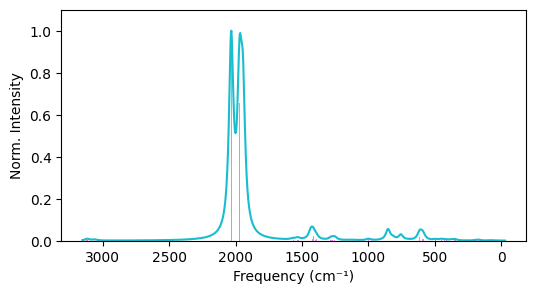

CPU times: user 1.11 s, sys: 312 ms, total: 1.42 s
Wall time: 38.7 s


In [ ]:
%%time
bpy = xTBWrapper(xyzpath='bpy.xyz')
bpy.xtb_alpb_optmize()
bpy.gfn_ir_calculation(solvent='DMF')
bpy.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> OMe.xyz

xtb /content/OMe.xyz --opt > optimize_gas.out
xtb xtbopt.xyz --opt --alpb DMF > optimize_sol_DMF.out
xtb tmp.xyz --hess --json --alpb DMF > gfn_ir_sol_DMF.out


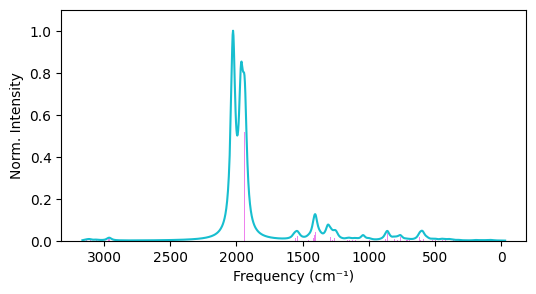

CPU times: user 1.25 s, sys: 420 ms, total: 1.67 s
Wall time: 50.1 s


In [ ]:
%%time
OMe = xTBWrapper(xyzpath='OMe.xyz')
OMe.xtb_alpb_optmize()
OMe.gfn_ir_calculation(solvent='DMF')
OMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> MeOMe.xyz

xtb /content/MeOMe.xyz --opt > optimize_gas.out
xtb xtbopt.xyz --opt --alpb DMF > optimize_sol_DMF.out
xtb tmp.xyz --hess --json --alpb DMF > gfn_ir_sol_DMF.out


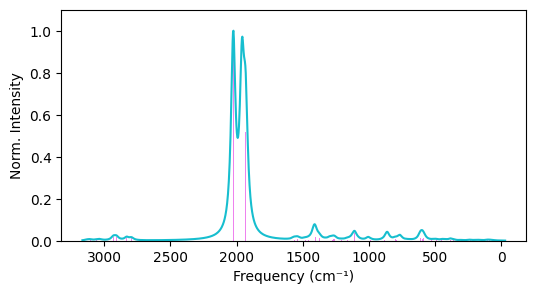

CPU times: user 1.28 s, sys: 379 ms, total: 1.66 s
Wall time: 57.5 s


In [ ]:
%%time
MeOMe = xTBWrapper(xyzpath='MeOMe.xyz')
MeOMe.xtb_alpb_optmize()
MeOMe.gfn_ir_calculation(solvent='DMF')
MeOMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> EtOMe.xyz

xtb /content/EtOMe.xyz --opt > optimize_gas.out
xtb xtbopt.xyz --opt --alpb DMF > optimize_sol_DMF.out
xtb tmp.xyz --hess --json --alpb DMF > gfn_ir_sol_DMF.out


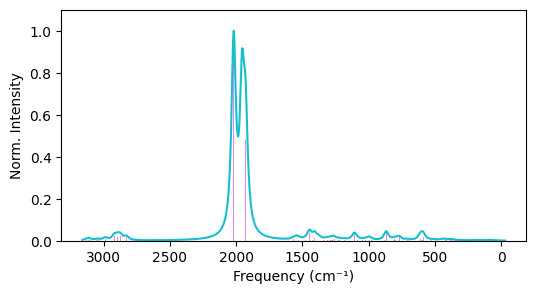

CPU times: user 1.4 s, sys: 477 ms, total: 1.88 s
Wall time: 60 s


In [ ]:
%%time
EtOMe = xTBWrapper(xyzpath='EtOMe.xyz')
EtOMe.xtb_alpb_optmize()
EtOMe.gfn_ir_calculation(solvent='DMF')
EtOMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> PrOMe.xyz

xtb /content/PrOMe.xyz --opt > optimize_gas.out
xtb xtbopt.xyz --opt --alpb DMF > optimize_sol_DMF.out
xtb tmp.xyz --hess --json --alpb DMF > gfn_ir_sol_DMF.out


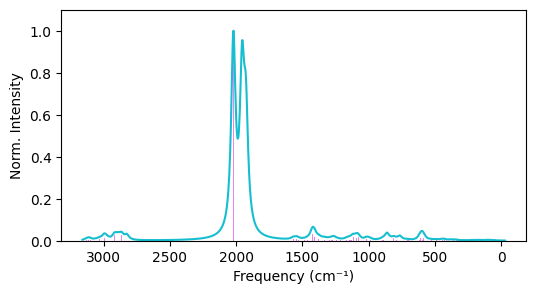

CPU times: user 1.62 s, sys: 458 ms, total: 2.08 s
Wall time: 1min 21s


In [ ]:
%%time
PrOMe = xTBWrapper(xyzpath='PrOMe.xyz')
PrOMe.xtb_alpb_optmize()
PrOMe.gfn_ir_calculation(solvent='DMF')
PrOMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> DiMeOMe.xyz

xtb /content/DiMeOMe.xyz --opt > optimize_gas.out
xtb xtbopt.xyz --opt --alpb DMF > optimize_sol_DMF.out
xtb tmp.xyz --hess --json --alpb DMF > gfn_ir_sol_DMF.out


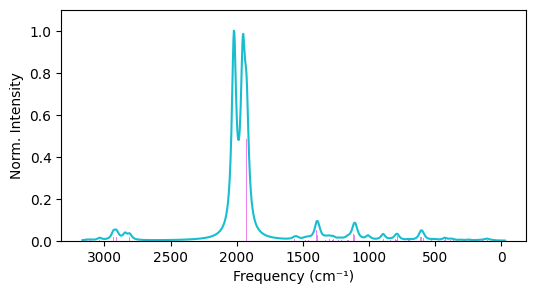

CPU times: user 1.74 s, sys: 491 ms, total: 2.23 s
Wall time: 1min 12s


In [ ]:
%%time
DiMeOMe = xTBWrapper(xyzpath='DiMeOMe.xyz')
DiMeOMe.xtb_alpb_optmize()
DiMeOMe.gfn_ir_calculation(solvent='DMF')
DiMeOMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> reporduce in solvation phase

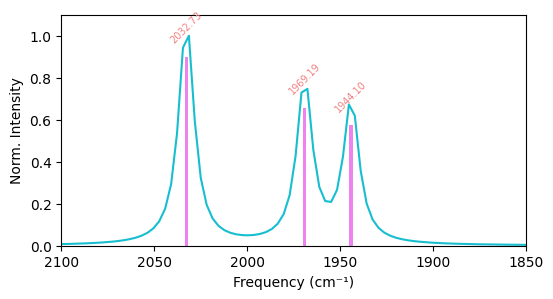

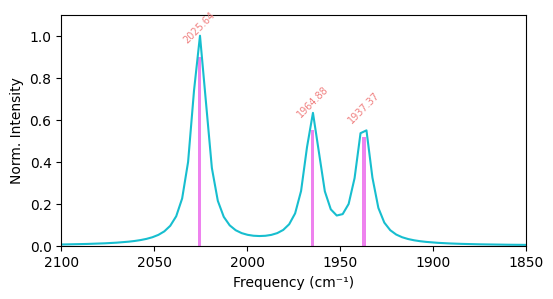

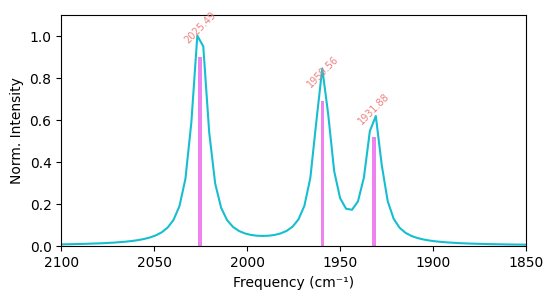

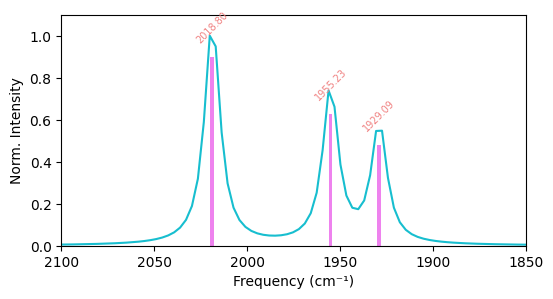

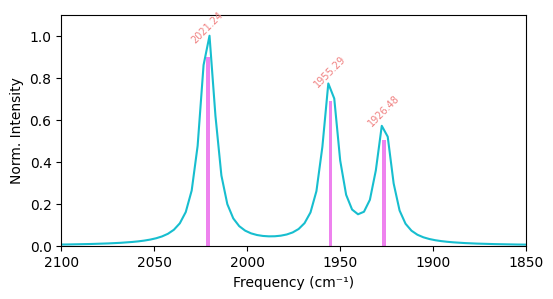

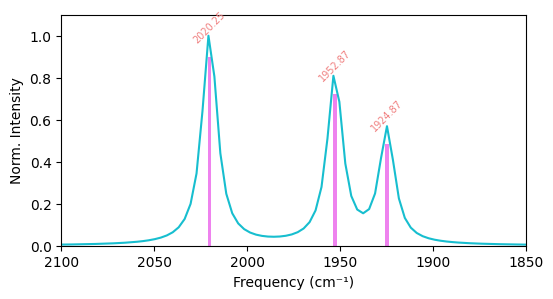

In [ ]:
bpy.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
OMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
MeOMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
EtOMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
PrOMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
DiMeOMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)

In [ ]:
bpy.view()
OMe.view()
MeOMe.view()
EtOMe.view()
PrOMe.view()
DiMeOMe.view()

<font color=pink size=6> gas phase IR Analysis</font> (in level of GFN2-xTB/PTB method)

> bpy.xyz

xtb /content/bpy.xyz --opt > optimize_gas.out
xtb tmp.xyz --ptb --hess --raman --json > ptb_ir_gas.out


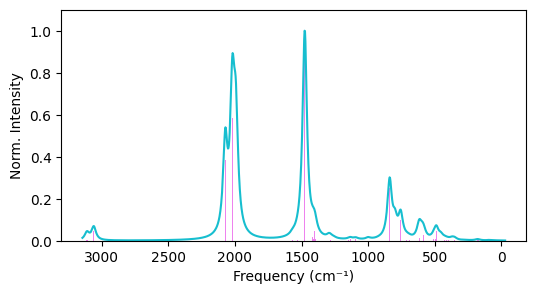

CPU times: user 9.63 s, sys: 3.96 s, total: 13.6 s
Wall time: 5min 26s


In [ ]:
%%time
bpy.xtb_gas_optimize()
bpy.ptb_ir_calculation()
bpy.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> OMe.xyz

xtb /content/OMe.xyz --opt > optimize_gas.out
xtb tmp.xyz --ptb --hess --raman --json > ptb_ir_gas.out


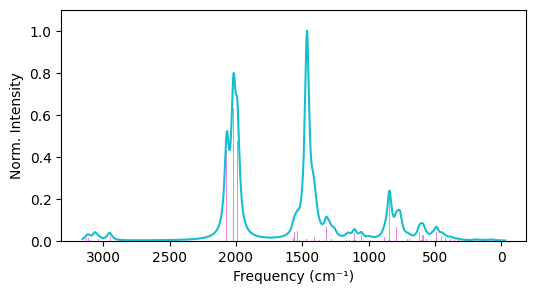

CPU times: user 12.3 s, sys: 5.65 s, total: 18 s
Wall time: 7min 47s


In [ ]:
%%time
OMe.xtb_gas_optimize()
OMe.ptb_ir_calculation()
OMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> MeOMe.xyz

xtb /content/MeOMe.xyz --opt > optimize_gas.out
xtb tmp.xyz --ptb --hess --raman --json > ptb_ir_gas.out


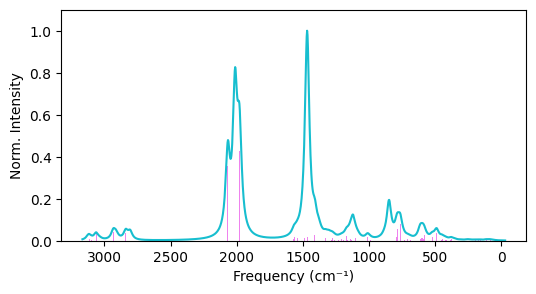

CPU times: user 15.2 s, sys: 7.08 s, total: 22.3 s
Wall time: 9min 49s


In [ ]:
%%time
MeOMe.xtb_gas_optimize()
MeOMe.ptb_ir_calculation()
MeOMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> EtOMe.xyz

xtb /content/EtOMe.xyz --opt > optimize_gas.out
xtb tmp.xyz --ptb --hess --raman --json > ptb_ir_gas.out


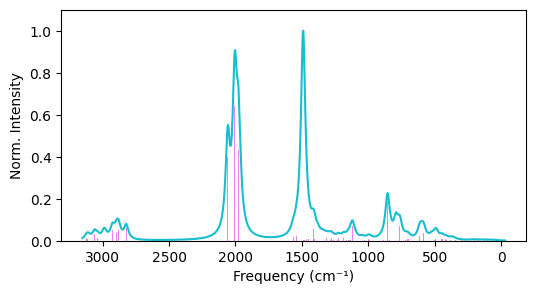

CPU times: user 18.6 s, sys: 8.53 s, total: 27.2 s
Wall time: 11min 51s


In [ ]:
%%time
EtOMe.xtb_gas_optimize()
EtOMe.ptb_ir_calculation()
EtOMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> PrOMe.xyz

xtb /content/PrOMe.xyz --opt > optimize_gas.out
xtb tmp.xyz --ptb --hess --raman --json > ptb_ir_gas.out


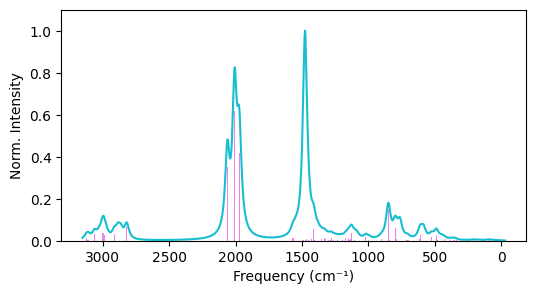

CPU times: user 21.8 s, sys: 10.4 s, total: 32.2 s
Wall time: 14min 26s


In [ ]:
%%time
PrOMe.xtb_gas_optimize()
PrOMe.ptb_ir_calculation()
PrOMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

> DiMeOMe.xyz

xtb /content/DiMeOMe.xyz --opt > optimize_gas.out
xtb tmp.xyz --ptb --hess --raman --json > ptb_ir_gas.out


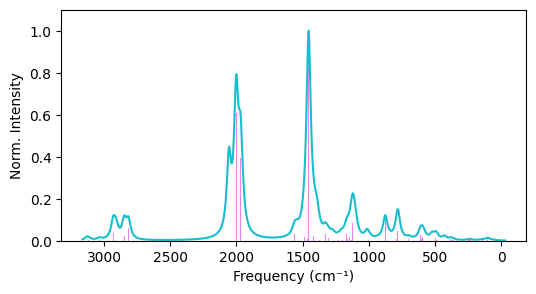

CPU times: user 22.7 s, sys: 10.5 s, total: 33.2 s
Wall time: 15min 7s


In [ ]:
%%time
DiMeOMe.xtb_gas_optimize()
DiMeOMe.ptb_ir_calculation()
DiMeOMe.ir_spectrum()#gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2)

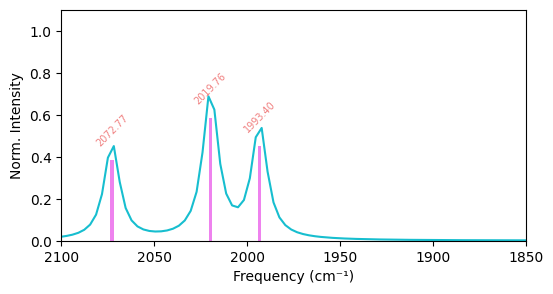

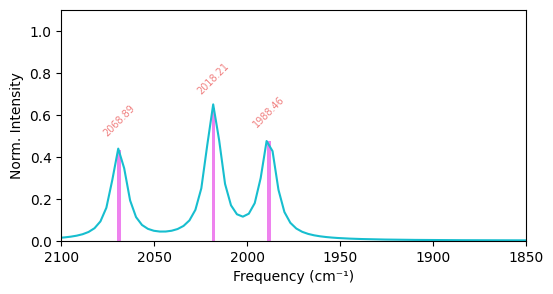

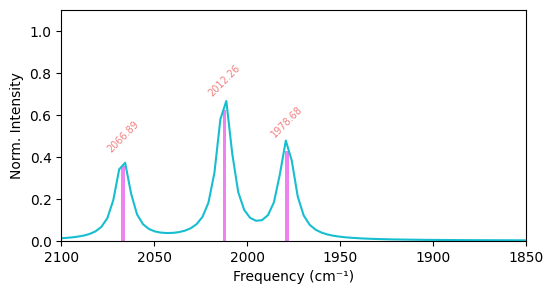

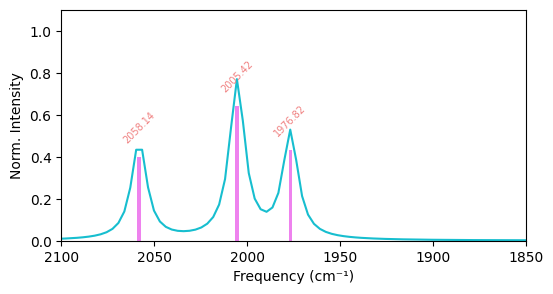

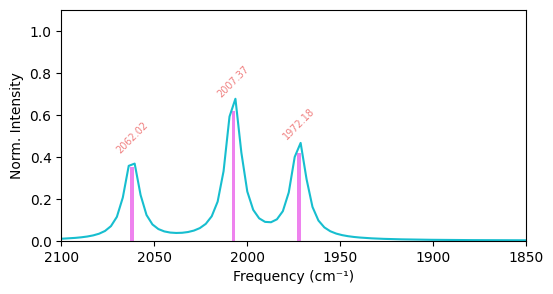

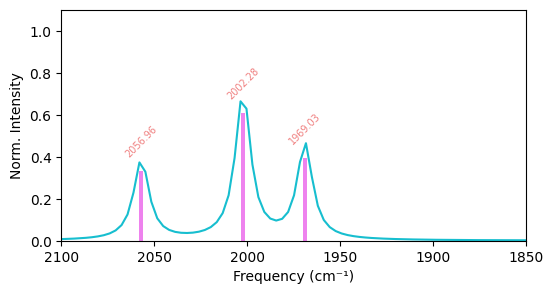

In [ ]:
bpy.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
OMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
MeOMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
EtOMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
PrOMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)
DiMeOMe.ir_spectrum(gamma_or_sigma=5, xrng=(1850, 2100), bar_width=2, annotate=True)

In [ ]:
bpy.view()
OMe.view()
MeOMe.view()
EtOMe.view()
PrOMe.view()
DiMeOMe.view()

In [ ]:
# TODO
# normal mode animation

In [ ]:
#@title deprecated
import numpy as np
import matplotlib.pyplot as plt
def _plot_ir_spectrum(freq, intensity, **kwargs):
    """
    Plot IR spectrum with Lorentzian or Gaussian broadening.

    Parameters:
    - freq: List or array of peak frequencies (cm⁻¹)
    - intensity: List or array of peak intensities
    - gamma_or_sigma: Half-width for Lorentzian or sigma for Gaussian (default: 20 cm⁻¹)
    """
    num_points = kwargs.get('num_points', 1000)
    bar_width = kwargs.get('bar_width',5)
    intensity_scale = kwargs.get('intensity_scale', 0.9)
    gamma_or_sigma = kwargs.get('gamma_or_sigma', 20)
    freq_padding = kwargs.get('freq_padding', 30)
    xrng = kwargs.get('xrng', None)
    annotate = kwargs.get('annotate', True)

    freq = np.array(freq)
    intensity = np.array(intensity)

    # 주파수 범위 설정
    x = np.linspace((freq[0]-freq_padding), (freq[-1]+freq_padding), num_points)

    def _lorentzian(x, x0, gamma, A):
        return A * (gamma / ((x - x0)**2 + gamma**2))

    # 전체 스펙트럼 초기화
    spectrum = np.zeros_like(x)

    for f, i in zip(freq, intensity):
        spectrum += _lorentzian(x, f, gamma_or_sigma, i)

    # normalization
    spectrum /= np.max(spectrum)
    intensity /= np.max(intensity)
    intensity *= intensity_scale


    # plot
    plt.figure(figsize=(6, 3))
    plt.plot(x, spectrum, color='tab:cyan', ls='-')
    plt.bar(freq, intensity, width=bar_width, color='violet', label='Original Peaks')
    if annotate:
        for x_pos, y_pos in zip(freq, intensity):
            plt.annotate(
                f"{x_pos:.2f}", (x_pos, y_pos), textcoords="offset points", xytext=(0, 10),
                ha="center", color="lightcoral", fontsize=7, rotation=45,
                )

    plt.xlabel('Frequency (cm⁻¹)')
    plt.ylabel('Norm. Intensity')
    if xrng:
        plt.xlim(xrng)
    plt.ylim(0, 1.1)
    plt.gca().invert_xaxis()
    plt.show()

In [ ]:
#@title xtb wrapper class (deprecated)
import os
import subprocess
import shutil
import json
import ase.io
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt

class xTBWrapper:
    """xTB wrapper class
    """
    def __init__(self, xyzpath, job_dir=None, clear=True, cwd:str=os.getcwd()):
        assert self._xtb_installed(), 'xtb is not installed'
        self.cwd = cwd
        self.clear = clear
        self.outfile = dict()
        self.ptb_res = dict()

        xyz_name = os.path.splitext(os.path.basename(xyzpath))[0]
        self.job_dir = job_dir if job_dir else xyz_name
        self.xyzpath = os.path.abspath(xyzpath)
        self.atoms = ase.io.read(xyzpath, format='xyz')

    def _excute_ftn_job_dir(self, ftn, **kwargs):
        """change dir before execute function
        """
        os.makedirs(self.job_dir, exist_ok=True)
        try:
            os.chdir(self.job_dir)
            ftn(**kwargs)
        finally:
            os.chdir(self.cwd)

    def _xtb_installed(self):
        """check if xtb is installed
        """
        try:
            subprocess.run(["xtb", "--version"], check=True)
            return True
        except subprocess.CalledProcessError:
            return False

    def _xtb_optimize(self, xyz_path, solvent=None):
        """optimize structure in current dir
        """
        assert ase.io.read(xyz_path).get_chemical_symbols() == self.atoms.get_chemical_symbols(), 'xyz file is not matching self.atoms'
        cmd_list = ['xtb', xyz_path, '--opt']
        if solvent:
            cmd_list.append(f'--alpb {solvent}')
            phase = f'sol_{solvent}'
        else:
            phase = 'gas'
        cmd_list.extend(['>', f'optimize_{phase}.out'])

        print(' '.join(cmd_list))

        result = subprocess.run(" ".join(cmd_list), shell=True, capture_output=True, text=True)

        if result.returncode != 0:
            print(result.stderr)
            raise RuntimeError('xTB excuation failed !')

        assert os.path.exists('xtbopt.xyz'), 'xtbopt.xyz not found'
        atoms = ase.io.read('xtbopt.xyz', format='xyz')
        self.atoms = atoms

    def xtb_gas_optimize(self):
        """optimize structure in gas phase
        """
        self._excute_ftn_job_dir(
            ftn=self._xtb_optimize,
            xyz_path=self.xyzpath,
            solvent=None
            )

    def xtb_alpb_optmize(self, solvent='DMF'):
        """optimize structure with alpb solvation model
        """
        if os.path.exists('xtbopt.xyz'):
            os.remove('xtbopt.xyz')

        self._excute_ftn_job_dir(
            ftn=self._xtb_optimize,
            xyz_path=self.xyzpath,
            solvent=None
            )

        self._excute_ftn_job_dir(
            ftn=self._xtb_optimize,
            xyz_path='xtbopt.xyz',
            solvent=solvent
        )

    def ptb_ir_calculation(self, solvent=None):
        """ptb calculation & IR analysis
        """

        cmd_list = ['xtb', 'tmp.xyz', '--ptb', '--hess', '--raman', '--json']
        if solvent:
            raise NotImplementedError('PTB does not yet support solvation methods')
        cmd_list.extend(['>', f'ptb_ir_gas.out'])

        try:
            os.chdir(self.job_dir)
            ase.io.write('tmp.xyz', self.atoms, format='xyz')
            print(' '.join(cmd_list))

            result = subprocess.run(" ".join(cmd_list), shell=True, capture_output=True, text=True)

            if result.returncode != 0:
                print(result.stderr)
                raise RuntimeError('xTB excuation failed !')

            self.ptb_res = json.load(open('xtbout.json', 'r'))
        finally:
            os.chdir(self.cwd)


    def gfn_ir_calculation(self, solvent=None):
        """ptb calculation & IR analysis
        """

        cmd_list = ['xtb', 'tmp.xyz', '--hess', '--json']
        if solvent:
            cmd_list.append(f'--alpb {solvent}')
            phase = f'sol_{solvent}'
        else:
            phase = 'gas'
        cmd_list.extend(['>', f'gfn_ir_{phase}.out'])

        try:
            os.chdir(self.job_dir)
            ase.io.write('tmp.xyz', self.atoms, format='xyz')
            print(' '.join(cmd_list))

            result = subprocess.run(" ".join(cmd_list), shell=True, capture_output=True, text=True)

            if result.returncode != 0:
                print(result.stderr)
                raise RuntimeError('xTB excuation failed !')

            self.ptb_res = json.load(open('xtbout.json', 'r'))
        finally:
            os.chdir(self.cwd)

    def view(self):
        """view structure
        """
        display(view(self.atoms, viewer='x3d'))

    def _excute_xtb(self, cmd_list:list):
        res = subprocess.run(
            cmd_list,
            shell=True,
            capture_output=True,
            text=True
            )
        print(res.stderr)

    def _plot_ir_spectrum(self, freq, intensity, **kwargs):
        """
        Plot IR spectrum with Lorentzian or Gaussian broadening.

        Parameters:
        - freq: List or array of peak frequencies (cm⁻¹)
        - intensity: List or array of peak intensities
        - gamma_or_sigma: Half-width for Lorentzian or sigma for Gaussian (default: 20 cm⁻¹)
        """
        num_points = kwargs.get('num_points', 1000)
        bar_width = kwargs.get('bar_width',5)
        intensity_scale = kwargs.get('intensity_scale', 0.9)
        gamma_or_sigma = kwargs.get('gamma_or_sigma', 20)
        freq_padding = kwargs.get('freq_padding', 30)
        xrng = kwargs.get('xrng', None)
        annotate = kwargs.get('annotate', False)


        freq = np.array(freq)
        intensity = np.array(intensity)

        # set x range
        x = np.linspace((freq[0]-freq_padding), (freq[-1]+freq_padding), num_points)

        def _lorentzian(x, x0, gamma, A):
            return A * (gamma / ((x - x0)**2 + gamma**2))

        # initialize spectrum
        spectrum = np.zeros_like(x)

        for f, i in zip(freq, intensity):
            spectrum += _lorentzian(x, f, gamma_or_sigma, i)

        # normalization
        spectrum /= np.max(spectrum)
        intensity /= np.max(intensity)
        intensity *= intensity_scale

        # plot
        plt.figure(figsize=(6, 3))
        plt.plot(x, spectrum, color='tab:cyan', ls='-')
        plt.bar(freq, intensity, width=bar_width, color='violet', label='Original Peaks')
        if annotate:
            for x_pos, y_pos in zip(freq, intensity):
                plt.annotate(
                    f"{x_pos:.2f}", (x_pos, y_pos), textcoords="offset points", xytext=(0, 10),
                    ha="center", color="lightcoral", fontsize=7, rotation=45,
                    )
        plt.xlabel('Frequency (cm⁻¹)')
        plt.ylabel('Norm. Intensity')
        if xrng:
            plt.xlim(xrng)
        plt.ylim(0, 1.1)
        plt.gca().invert_xaxis()
        plt.show()

    def ir_spectrum(self, **kwargs):
        """plot IR spectrum
        """
        plot_data = (self.ptb_res['vibrational frequencies / rcm'], self.ptb_res['IR intensities / km/mol'])
        self._plot_ir_spectrum(*plot_data, **kwargs)